<h3>Import Library</h3>

In [1]:
import os
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
from pylab import array, plot, show, axis, arange, figure, uint8 

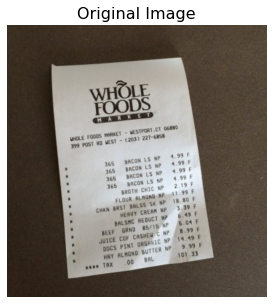

In [2]:
#@markdown <h3> 🖼️ เลือกรูปภาพ Choose An Image</h3>
#@markdown <small>สามารถเลือกภาพตัวอย่างหรือจะอัพโหลดภาพของคุณ Pick the preset image or upload your own image</small>
#@title
from google.colab import files
from IPython.display import HTML

image = '\uD83E\uDDFE receipt' #@param ['🗏 page', '🧾 receipt', '📤 upload your image']

image = ' '.join(image.split(' ')[1:])
onedrive_dataset = None

image_url = {
  'page': 'https://tuipied-my.sharepoint.com/:i:/g/personal/sarung_staff_tu_ac_th/EYrbOpH-4KxKh92HODIIu14BtZ-2t7tPW2BAqpK9cpCPwA?download=1',
  'receipt': 'https://tuipied-my.sharepoint.com/:i:/g/personal/sarung_staff_tu_ac_th/Eas6Z4A_v0JBr8r-AEgh8VQBeOoOWC2tdZtEPc_CJ3RPNw?download=1',
}

if image == 'upload your image': onedrive_dataset = ':images_upload:'
elif image in image_url:  onedrive_dataset = image_url[image]
if onedrive_dataset == None: raise Exception('Cannot select image')

preupload_datasets = None
if onedrive_dataset == ':images_upload:':
  display(HTML('<h3>Select your image</h3>'))
  dir = os.getcwd()
  uploaded = files.upload()
  preupload_datasets = [os.path.join(dir, f) for f in uploaded.keys()]
  image_fn = preupload_datasets[0]
else:
  get_ipython().system_raw('wget -O image.jpg ' + onedrive_dataset)
  image_fn = 'image.jpg'

im = cv2.imread(image_fn)
plt.figure(figsize=(5, 5))
plt.title('Original Image',fontsize=16)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

## Edge Detection



*   แปลงจาก BGR เป็น Grayscale
*   ทำการเบลอรูปภาพ
*   หาขอบภาพด้วยเทคนิค Canny Edge Detection



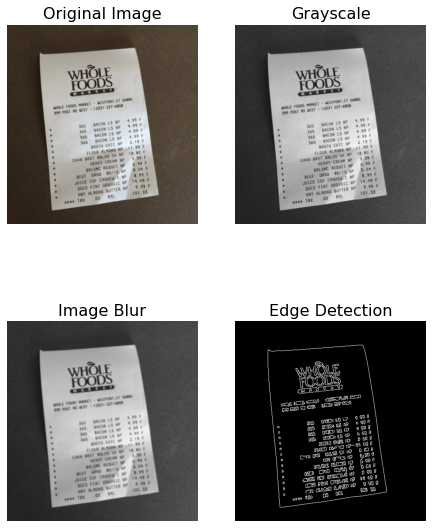

In [3]:
#@title
img = im.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(gray, (3, 3), 0)
edge = cv2.Canny(img_blur , 30, 250)

plt.figure(figsize=(7.5, 10))
plt.subplot(221), plt.title('Original Image', fontsize = 16)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(222), plt.title('Grayscale', fontsize = 16)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(223), plt.title('Image Blur', fontsize = 16)
plt.imshow(cv2.cvtColor(img_blur, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(224), plt.title('Edge Detection', fontsize = 16)
plt.imshow(cv2.cvtColor(edge, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

## Contour



* หา contour 
* วาด contour ที่ได้ลงบนภาพ




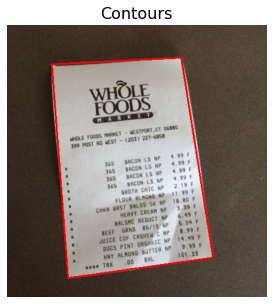

In [4]:
#@title
contours = cv2.findContours(edge.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

for c in contours:
  peri = cv2.arcLength(c, True)
  approx = cv2.approxPolyDP(c, 0.02 * peri, True)

  if len(approx) == 4:
    screenCnt = approx
    break

contour = cv2.drawContours(img, [screenCnt], -1, (0, 0, 255), thickness = 2)

plt.figure(figsize=(5, 5))
plt.title('Contours', fontsize = 16)
plt.imshow(cv2.cvtColor(contour, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

## Perspective Transform



*   การหาพิกัดจุดมุม
*   คำนวณหามุม
*   ทำ Perspective Transform



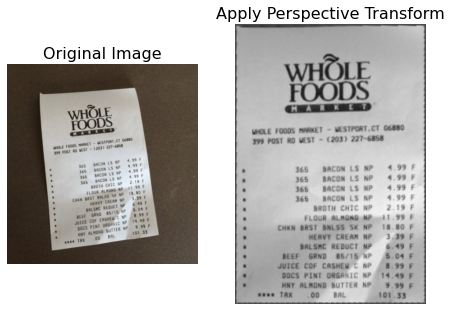

In [5]:
#@title
def order_points(pts):
	rect = np.zeros((4, 2), dtype = "float32")
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	return rect

def four_point_transform(im, pts):
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(im, M, (maxWidth, maxHeight))
	return warped

orig = img.copy()
warped = four_point_transform(orig, screenCnt.reshape(4, 2))

warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
warped = cv2.cvtColor(warped, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(7.5, 7.5))
plt.subplot(121), plt.title('Original Image', fontsize = 16)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(122), plt.title('Apply Perspective Transform', fontsize = 16)
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

## Brightness Adjustment



*   การเพิ่มความเข้มแสง
*   การลดความเข้มแสง
*   กราฟแสดงการเพิ่ม-ลดความเข้มแสง



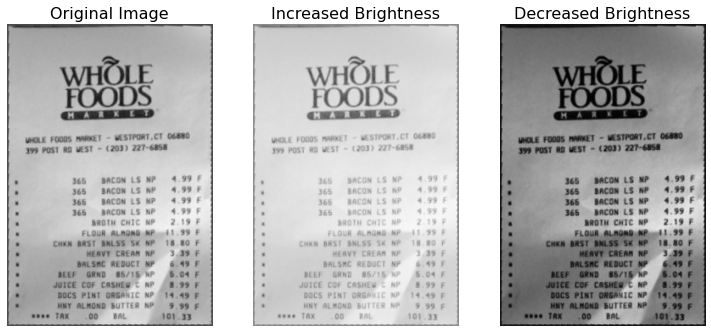

In [6]:
#@title
from pylab import array, plot, show, axis, arange, figure, uint8 
IMG = warped.copy()

maxIntensity = 255.0

phi = 1
theta = 1

increase_bn = (maxIntensity/phi)*(IMG/(maxIntensity/theta))**0.5
increase_bn = array(increase_bn,dtype=uint8)

decrease_bn = (maxIntensity/phi)*(IMG/(maxIntensity/theta))**2
decrease_bn = array(decrease_bn,dtype=uint8)

plt.figure(figsize=(12.5,12.5))
plt.subplot(131), plt.title('Original Image', fontsize = 16)
plt.imshow(cv2.cvtColor(IMG, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(132), plt.title('Increased Brightness', fontsize = 16)
plt.imshow(cv2.cvtColor(increase_bn, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(133), plt.title('Decreased Brightness', fontsize = 16)
plt.imshow(cv2.cvtColor(decrease_bn, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

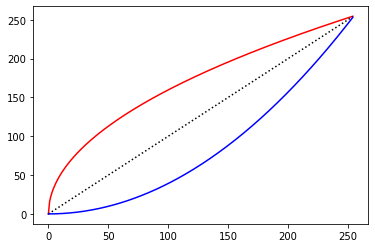

In [7]:
#@title
x = arange(maxIntensity)
y = (maxIntensity/phi)*(x/(maxIntensity/theta))**0.5
z = (maxIntensity/phi)*(x/(maxIntensity/theta))**2

# Plot the figures
figure()
plot(x,y,'r-') # Increased brightness
plot(x,x,'k:') # Original image
plot(x,z, 'b-') # Decreased brightness
axis('tight')
show()

## Image Sharpening


*   สร้าง kernel เพื่อเฉลี่ยความเข้มของ pixel แต่ละอัน
*   นำ kernel มาทำ convolution ใน array ของรูปภาพ


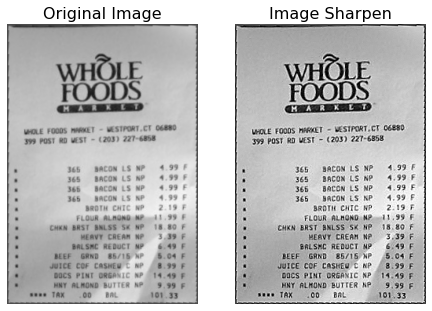

In [8]:
#@title
image = warped.copy()

kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])

image_sharp = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)

plt.figure(figsize=(7.5, 7.5))
plt.subplot(121), plt.title('Original Image', fontsize = 16)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(122), plt.title('Image Sharpen', fontsize = 16)
plt.imshow(image_sharp)
plt.axis('off')
plt.show()

## Contrast Adjustment



*   สร้าง Contrast Limited Adaptive Histogram Equalization(CLAHE)
*   แปลงรูปภาพจาก BGR เป็น Lab color space
*   แยกสีของภาพออกเป็น list ของค่าแต่ละสี
*   นำไปปรับใช้กับรูปภาพที่ต้องการแปลง
*   รวม list ของค่าแต่ละสีเข้าเป็น array ของภาพสี
*   แปลงจาก LAB กลับเป็น BGR



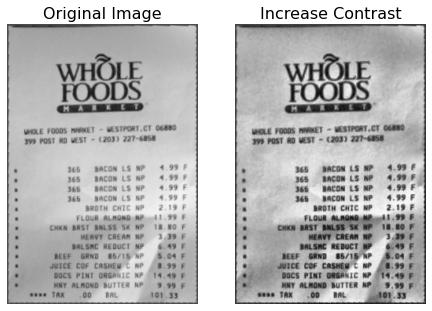

In [9]:
#@title
clahe = cv2.createCLAHE(clipLimit=3., tileGridSize=(8,8))

lab = cv2.cvtColor(warped, cv2.COLOR_BGR2LAB)  # convert from BGR to LAB color space
l, a, b = cv2.split(lab)  # split on 3 different channels

l2 = clahe.apply(l)  # apply CLAHE to the L-channel

lab = cv2.merge((l2,a,b))  # merge channels
img2 = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  # convert from LAB to BGR

plt.figure(figsize=(7.5,7.5))
plt.subplot(121), plt.title('Original Image', fontsize = 16)
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(122), plt.title('Increase Contrast', fontsize = 16)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()